In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('Transformed_dataset.csv')

In [17]:
df['Shortage'] =  df['Total_Generation'] - df['Total_Consumption']

In [18]:
df

,Date_Timestamp,DayOfWeek,Month,HourOfDay,Consumption_B1,Consumption_B2,Consumption_B3,Generation_1,Generation_2,Generation_3,...,Temperature (c),relative_humidity_2m (%),dew_point_2m (¬∞C),precipitation (mm),cloud_cover (%),Cloud_Cover_Category,wind_speed_10m (km/h),Total_Consumption,Total_Generation,Shortage
0,1/1/19 0:30,1,1,0,263.934730,119.965555,100.382488,0.0,0.0,0.0,...,0.24,87,-1.7,0.0,56,Partly Cloudy,7.2,484.282773,0.0,-484.282773
1,1/1/19 1:30,1,1,1,261.381617,126.873583,98.777157,0.0,0.0,0.0,...,0.33,87,-1.6,0.0,100,Overcast,7.6,487.032358,0.0,-487.032358
2,1/1/19 2:30,1,1,2,289.598378,130.980467,109.956200,0.0,0.0,0.0,...,0.36,88,-1.5,0.0,94,Overcast,5.9,530.535045,0.0,-530.535045
3,1/1/19 3:30,1,1,3,340.806009,143.535150,129.512557,0.0,0.0,0.0,...,0.21,88,-1.6,0.0,88,Overcast,5.5,613.853717,0.0,-613.853717
4,1/1/19 4:30,1,1,4,399.536718,174.588548,150.485312,0.0,0.0,0.0,...,0.03,88,-1.7,0.0,81,Overcast,6.4,724.610577,0.0,-724.610577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,12/31/20 19:30,3,12,19,240.822001,185.668900,97.548156,0.0,0.0,0.0,...,2.44,99,2.2,0.0,35,Mostly Clear,4.6,524.039056,0.0,-524.039056
17516,12/31/20 20:30,3,12,20,225.928331,178.478517,92.432246,0.0,0.0,0.0,...,1.91,100,1.8,0.0,45,Partly Cloudy,4.8,496.839094,0.0,-496.839094
17517,12/31/20 21:30,3,12,21,200.289301,164.246147,83.005720,0.0,0.0,0.0,...,1.51,100,1.4,0.0,35,Mostly Clear,4.7,447.541168,0.0,-447.541168
17518,12/31/20 22:30,3,12,22,184.485978,145.000653,80.381694,0.0,0.0,0.0,...,1.44,99,1.2,0.0,39,Mostly Clear,5.8,409.868325,0.0,-409.868325


In [9]:
# Define the MAPE function
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
X_Shortage = df.drop(['Date_Timestamp','Total_Consumption', 'Total_Generation','Consumption_B2','Consumption_B3','Generation_1','Generation_3','Shortage','Cloud_Cover_Category'], axis=1)
y_Shortage = df['Shortage']

# Split the data into training and testing sets
X_train_Shortage, X_test_Shortage, y_train_Shortage, y_test_Shortage = train_test_split(X_Shortage, y_Shortage, test_size=0.042, random_state=42, shuffle=False)

In [20]:
param_grid_xgb = {
    'n_estimators': [100],
    'max_depth': [5],
    'learning_rate': [0.1]
}

# Initialize the XGBoost regressor
xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgbr, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error')

# Fit the XGBoost model with the training data
grid_search_xgb.fit(X_train_Shortage, y_train_Shortage)

# Get the best hyperparameters from the grid search
best_params_xgb = grid_search_xgb.best_params_
print("Best XGBoost Hyperparameters:", best_params_xgb)

# Use the best XGBoost model for prediction
best_xgb_model_Shortage = grid_search_xgb.best_estimator_
y_pred_xgb_Shortage = best_xgb_model_Shortage.predict(X_test_Shortage)

# Evaluate the XGBoost model
rmse_xgb = np.sqrt(mean_squared_error(y_test_Shortage, y_pred_xgb_Shortage))
print(f"XGBoost RMSE: {rmse_xgb}")

mae_xgb = mean_absolute_error(y_test_Shortage, y_pred_xgb_Shortage)
print(f"XGBoost MAE: {mae_xgb}")

Best XGBoost Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
XGBoost RMSE: 79.0863867967736
XGBoost MAE: 45.881517406856574


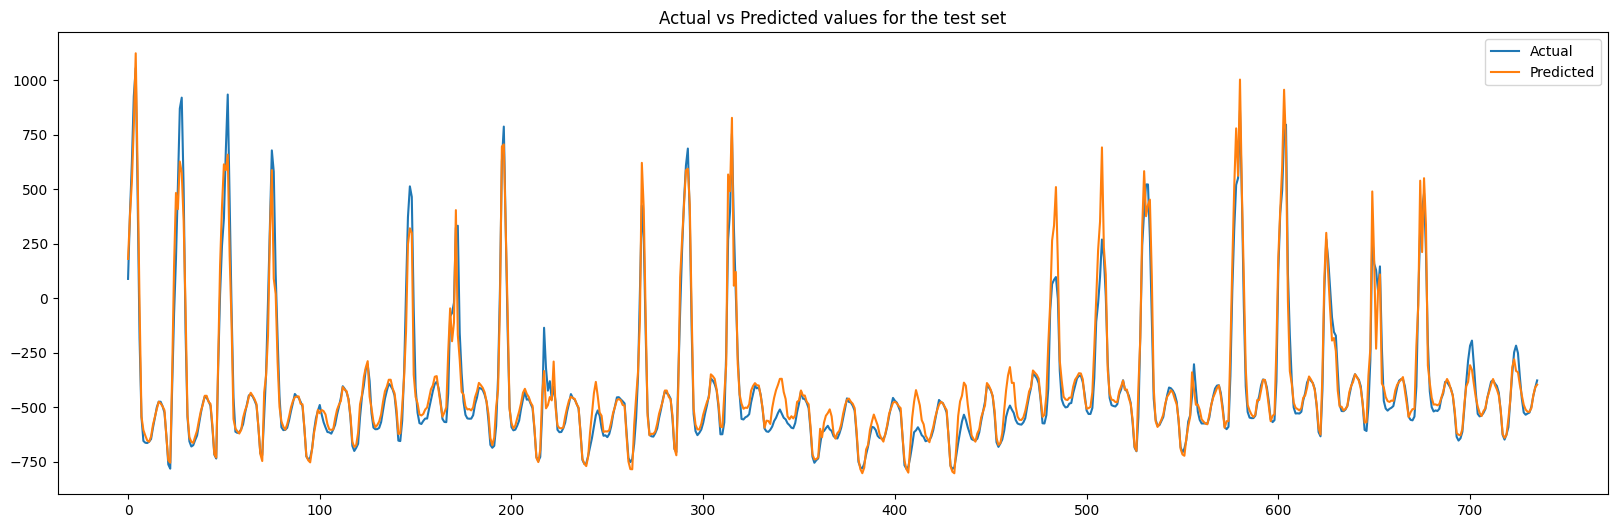

In [24]:
#Plotting the actual vs predicted values for the test set
plt.figure(figsize=(20, 6))
y_test1_consumption = y_test_Shortage.to_numpy()
plt.plot(y_test1_consumption, label='Actual')
plt.plot(y_pred_xgb_Shortage, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted values for the test set")
plt.show()

In [23]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Define the parameter grid for SVR
param_grid_svr = {
    'C': [10],
    'epsilon': [0.5],
    'kernel': ['linear','rbf']
}
# param_grid_svr = {
#     'C': [0.1, 1, 10],
#     'epsilon': [0.1, 0.2, 0.5],
#     'kernel': ['linear', 'rbf', 'poly']
# }

# Initialize the SVR model
svr = SVR()

# Initialize GridSearchCV for SVR
grid_search_svr = GridSearchCV(estimator=svr, param_grid=param_grid_svr, cv=5, scoring='neg_mean_squared_error')

# Fit the SVR model with the training data
grid_search_svr.fit(X_train_Shortage, y_train_Shortage)

# Get the best hyperparameters from the grid search
best_params_svr = grid_search_svr.best_params_
print("Best SVR Hyperparameters:", best_params_svr)

# Use the best SVR model for prediction
best_svr_model_Shortage = grid_search_svr.best_estimator_
y_pred_svr_Shortage = best_svr_model_Shortage.predict(X_test_Shortage)

# Evaluate the SVR model
rmse_svr = np.sqrt(mean_squared_error(y_test_Shortage, y_pred_svr_Shortage))
print(f"SVR RMSE: {rmse_svr}")

mae_svr = mean_absolute_error(y_test_Shortage, y_pred_svr_Shortage)
print(f"SVR MAE: {mae_svr}")

Best SVR Hyperparameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}
SVR RMSE: 147.34800396353083
SVR MAE: 74.17676093237829


In [27]:
df1 = df

In [28]:
df1.head(20)

,Date_Timestamp,DayOfWeek,Month,HourOfDay,Consumption_B1,Consumption_B2,Consumption_B3,Generation_1,Generation_2,Generation_3,...,Temperature (c),relative_humidity_2m (%),dew_point_2m (¬∞C),precipitation (mm),cloud_cover (%),Cloud_Cover_Category,wind_speed_10m (km/h),Total_Consumption,Total_Generation,Shortage
0,1/1/19 0:30,1,1,0,263.934730,119.965555,100.382488,0.000000,0.000000,0.000000,...,0.24,87,-1.7,0.0,56,Partly Cloudy,7.2,484.282773,0.000000,-484.282773
1,1/1/19 1:30,1,1,1,261.381617,126.873583,98.777157,0.000000,0.000000,0.000000,...,0.33,87,-1.6,0.0,100,Overcast,7.6,487.032358,0.000000,-487.032358
2,1/1/19 2:30,1,1,2,289.598378,130.980467,109.956200,0.000000,0.000000,0.000000,...,0.36,88,-1.5,0.0,94,Overcast,5.9,530.535045,0.000000,-530.535045
3,1/1/19 3:30,1,1,3,340.806009,143.535150,129.512557,0.000000,0.000000,0.000000,...,0.21,88,-1.6,0.0,88,Overcast,5.5,613.853717,0.000000,-613.853717
4,1/1/19 4:30,1,1,4,399.536718,174.588548,150.485312,0.000000,0.000000,0.000000,...,0.03,88,-1.7,0.0,81,Overcast,6.4,724.610577,0.000000,-724.610577
5,1/1/19 5:30,1,1,5,359.570304,251.327078,135.929211,0.000000,0.000000,0.000000,...,-0.49,91,-1.9,0.0,67,Mostly Cloudy,5.1,746.826593,0.000000,-746.826593
6,1/1/19 6:30,1,1,6,352.059444,247.050640,147.602814,0.000000,0.000000,0.000000,...,-0.56,90,-2.1,0.0,75,Mostly Cloudy,4.8,746.712898,0.000000,-746.712898
7,1/1/19 7:30,1,1,7,344.880960,239.038966,147.823253,0.000000,0.650407,0.000000,...,0.05,90,-1.5,0.0,86,Overcast,3.2,731.743179,0.650407,-731.092773
8,1/1/19 8:30,1,1,8,329.569168,237.915319,135.971290,14.358974,254.634146,17.341256,...,-0.19,92,-1.4,0.0,89,Overcast,4.3,703.455776,286.334376,-417.121400
9,1/1/19 9:30,1,1,9,314.838795,230.916968,129.750366,70.618401,644.552846,85.285463,...,0.43,88,-1.3,0.0,80,Mostly Cloudy,4.2,675.506128,800.456710,124.950582


In [29]:
def assign_severity(value):
    if value > 0:
        return 'Shortage'
    elif value < 0:
        return 'Abundance'

# Apply the function to create a new column with severity categories
df1['severity'] = df1['Shortage'].apply(assign_severity)

df1.head(20)

,Date_Timestamp,DayOfWeek,Month,HourOfDay,Consumption_B1,Consumption_B2,Consumption_B3,Generation_1,Generation_2,Generation_3,...,relative_humidity_2m (%),dew_point_2m (¬∞C),precipitation (mm),cloud_cover (%),Cloud_Cover_Category,wind_speed_10m (km/h),Total_Consumption,Total_Generation,Shortage,severity
0,1/1/19 0:30,1,1,0,263.934730,119.965555,100.382488,0.000000,0.000000,0.000000,...,87,-1.7,0.0,56,Partly Cloudy,7.2,484.282773,0.000000,-484.282773,Abundance
1,1/1/19 1:30,1,1,1,261.381617,126.873583,98.777157,0.000000,0.000000,0.000000,...,87,-1.6,0.0,100,Overcast,7.6,487.032358,0.000000,-487.032358,Abundance
2,1/1/19 2:30,1,1,2,289.598378,130.980467,109.956200,0.000000,0.000000,0.000000,...,88,-1.5,0.0,94,Overcast,5.9,530.535045,0.000000,-530.535045,Abundance
3,1/1/19 3:30,1,1,3,340.806009,143.535150,129.512557,0.000000,0.000000,0.000000,...,88,-1.6,0.0,88,Overcast,5.5,613.853717,0.000000,-613.853717,Abundance
4,1/1/19 4:30,1,1,4,399.536718,174.588548,150.485312,0.000000,0.000000,0.000000,...,88,-1.7,0.0,81,Overcast,6.4,724.610577,0.000000,-724.610577,Abundance
5,1/1/19 5:30,1,1,5,359.570304,251.327078,135.929211,0.000000,0.000000,0.000000,...,91,-1.9,0.0,67,Mostly Cloudy,5.1,746.826593,0.000000,-746.826593,Abundance
6,1/1/19 6:30,1,1,6,352.059444,247.050640,147.602814,0.000000,0.000000,0.000000,...,90,-2.1,0.0,75,Mostly Cloudy,4.8,746.712898,0.000000,-746.712898,Abundance
7,1/1/19 7:30,1,1,7,344.880960,239.038966,147.823253,0.000000,0.650407,0.000000,...,90,-1.5,0.0,86,Overcast,3.2,731.743179,0.650407,-731.092773,Abundance
8,1/1/19 8:30,1,1,8,329.569168,237.915319,135.971290,14.358974,254.634146,17.341256,...,92,-1.4,0.0,89,Overcast,4.3,703.455776,286.334376,-417.121400,Abundance
9,1/1/19 9:30,1,1,9,314.838795,230.916968,129.750366,70.618401,644.552846,85.285463,...,88,-1.3,0.0,80,Mostly Cloudy,4.2,675.506128,800.456710,124.950582,Shortage


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Load your sample DataFrame
# Assuming your DataFrame is already loaded and named df1

# Define features (X) and target variable (y)
X_shortage = df1.drop(['Date_Timestamp','Total_Consumption', 'Total_Generation','Consumption_B1','Consumption_B2','Consumption_B3','Generation_2','Generation_1','Generation_3','Shortage','Cloud_Cover_Category', 'severity'], axis=1)
y_shortage = df1['severity']

# Label encoding for target variable y
label_encoder = LabelEncoder()
y_shortage_encoded = label_encoder.fit_transform(y_shortage)

# Split the data into training and testing sets
X_train_shortage, X_test_shortage, y_train_shortage, y_test_shortage = train_test_split(X_shortage, y_shortage_encoded, test_size=0.042, random_state=42, shuffle=False)

# Random Forest classifier
rf = RandomForestClassifier()

# Hyperparameter grid
param_grid = {
    'n_estimators': [150],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],

}

from sklearn.model_selection import StratifiedKFold

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Randomized Search Cross Validation with stratified K-fold
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=cv, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train_shortage, y_train_shortage)

# Best parameters
print("Best parameters found:", rf_random.best_params_)

# Evaluate the model
y_pred_shortage = rf_random.predict(X_test_shortage)

# Decode predictions
y_pred_shortage_decoded = label_encoder.inverse_transform(y_pred_shortage)

# Accuracy
accuracy_shortage = accuracy_score(y_test_shortage, y_pred_shortage)
print("Accuracy:", accuracy_shortage)

# Classification Report
print("Classification Report:")
print(classification_report(y_test_shortage, y_pred_shortage, target_names=label_encoder.classes_))



Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   2.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   2.9s
Best parameters found: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Accuracy: 0.9144021739130435
Classification Report:
              precision    recall  f1-score   support

   Abundance       0.92      0.99      0.95       654
    Shortage       0.83      0.29      0.43        82

    accuracy                           0.91       736
   macro avg       0.87      0.64      0.69       736
weighted avg       0.91      0.91      0.90       736



In [37]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Random Forest Regression
param_grid_rf = {
    'n_estimators': [200],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
}

rf = RandomForestRegressor()

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')

grid_search_rf.fit(X_train_Shortage, y_train_Shortage)

best_params_rf = grid_search_rf.best_params_
print("Best Random Forest Hyperparameters:", best_params_rf)

best_rf_model_Shortage = grid_search_rf.best_estimator_
y_pred_rf_Shortage = best_rf_model_Shortage.predict(X_test_Shortage)

rmse_rf = np.sqrt(mean_squared_error(y_test_Shortage, y_pred_rf_Shortage))
print(f"Random Forest RMSE: {rmse_rf}")

mae_rf = mean_absolute_error(y_test_Shortage, y_pred_rf_Shortage)
print(f"Random Forest MAE: {mae_rf}")

# Gradient Boosting Regression
param_grid_gb = {
    'n_estimators': [200],
    'learning_rate': [0.1],
    'max_depth': [5],
    'subsample': [0.8]
}

gb = GradientBoostingRegressor()

grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=5, scoring='neg_mean_squared_error')

grid_search_gb.fit(X_train_Shortage, y_train_Shortage)

best_params_gb = grid_search_gb.best_params_
print("Best Gradient Boosting Hyperparameters:", best_params_gb)

best_gb_model_Shortage = grid_search_gb.best_estimator_
y_pred_gb_Shortage = best_gb_model_Shortage.predict(X_test_Shortage)

rmse_gb = np.sqrt(mean_squared_error(y_test_Shortage, y_pred_gb_Shortage))
print(f"Gradient Boosting RMSE: {rmse_gb}")

mae_gb = mean_absolute_error(y_test_Shortage, y_pred_gb_Shortage)
print(f"Gradient Boosting MAE: {mae_gb}")


Best Random Forest Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest RMSE: 85.4384915569213
Random Forest MAE: 48.06965874709403
Best Gradient Boosting Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Gradient Boosting RMSE: 82.022250087858
Gradient Boosting MAE: 46.36374999694784


In [31]:
from sklearn.metrics import confusion_matrix

# Evaluate the model
y_pred_shortage = rf_random.predict(X_test_shortage)

# Decode predictions
y_pred_shortage_decoded = label_encoder.inverse_transform(y_pred_shortage)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_shortage, y_pred_shortage)

print("Confusion Matrix:")
print(conf_matrix)

# Accuracy
accuracy_shortage = accuracy_score(y_test_shortage, y_pred_shortage)
print("Accuracy:", accuracy_shortage)

# Classification Report
print("Classification Report:")
print(classification_report(y_test_shortage, y_pred_shortage, target_names=label_encoder.classes_))


Confusion Matrix:
[[649   5]
 [ 58  24]]
Accuracy: 0.9144021739130435
Classification Report:
              precision    recall  f1-score   support

   Abundance       0.92      0.99      0.95       654
    Shortage       0.83      0.29      0.43        82

    accuracy                           0.91       736
   macro avg       0.87      0.64      0.69       736
weighted avg       0.91      0.91      0.90       736



In [32]:
# Predicted scores
y_scores = rf_random.predict_proba(X_test_shortage)

# Convert predicted labels back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred_shortage)

# Actual labels
y_actual_labels = label_encoder.inverse_transform(y_test_shortage)

# Create a DataFrame to display actual vs predicted labels and scores
results_df = pd.DataFrame({'Actual_Label': y_actual_labels,
                           'Predicted_Label': y_pred_labels,
                           'Actual_Score': y_scores.max(axis=1),
                           'Predicted_Score': [score[label_encoder.transform([label])[0]] for score, label in zip(y_scores, y_pred_labels)]})

# Display the DataFrame
print("Actual vs Predicted:")
print(results_df)


Actual vs Predicted:
    Actual_Label Predicted_Label  Actual_Score  Predicted_Score
0       Shortage       Abundance      0.973333         0.973333
1       Shortage       Abundance      0.900000         0.900000
2       Shortage       Abundance      0.713333         0.713333
3       Shortage        Shortage      0.606667         0.606667
4       Shortage        Shortage      0.560000         0.560000
..           ...             ...           ...              ...
731    Abundance       Abundance      1.000000         1.000000
732    Abundance       Abundance      1.000000         1.000000
733    Abundance       Abundance      1.000000         1.000000
734    Abundance       Abundance      1.000000         1.000000
735    Abundance       Abundance      1.000000         1.000000

[736 rows x 4 columns]


In [33]:
# Calculate correct predictions
correct_predictions = (y_pred_shortage == y_test_shortage).sum()

# Calculate total predictions
total_predictions = len(y_test_shortage)

# Calculate incorrect predictions
incorrect_predictions = total_predictions - correct_predictions

print("Correct predictions:", correct_predictions)
print("Incorrect predictions:", incorrect_predictions)


Correct predictions: 673
Incorrect predictions: 63


In [34]:
from sklearn.svm import SVC

# SVM classifier
svm = SVC()

# Hyperparameter grid
param_grid_svm = {
    'C': [10],
    'gamma': ['auto'],
    'kernel': ['rbf']
}

# Randomized Search Cross Validation with stratified K-fold
svm_random = RandomizedSearchCV(estimator=svm, param_distributions=param_grid_svm, n_iter=100, cv=cv, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
svm_random.fit(X_train_shortage, y_train_shortage)

# Best parameters
print("Best parameters found:", svm_random.best_params_)

# Evaluate the model
y_pred_shortage_svm = svm_random.predict(X_test_shortage)

# Decode predictions
y_pred_shortage_decoded_svm = label_encoder.inverse_transform(y_pred_shortage_svm)

# Accuracy
accuracy_shortage_svm = accuracy_score(y_test_shortage, y_pred_shortage_svm)
print("Accuracy:", accuracy_shortage_svm)

# Classification Report
print("Classification Report:")
print(classification_report(y_test_shortage, y_pred_shortage_svm, target_names=label_encoder.classes_))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=  35.0s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=  35.2s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=  35.8s
Best parameters found: {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}
Accuracy: 0.8858695652173914
Classification Report:
              precision    recall  f1-score   support

   Abundance       0.89      1.00      0.94       654
    Shortage       0.25      0.01      0.02        82

    accuracy                           0.89       736
   macro avg       0.57      0.50      0.48       736
weighted avg       0.82      0.89      0.84       736



In [35]:
# Confusion matrix
conf_matrix_svm = confusion_matrix(y_test_shortage, y_pred_shortage_svm)
print("Confusion Matrix (SVM):")
print(conf_matrix_svm)

# Accuracy
accuracy_svm = accuracy_score(y_test_shortage, y_pred_shortage_svm)
print("Accuracy (SVM):", accuracy_svm)

# Classification Report
print("Classification Report (SVM):")
print(classification_report(y_test_shortage, y_pred_shortage_svm, target_names=label_encoder.classes_))


Confusion Matrix (SVM):
[[651   3]
 [ 81   1]]
Accuracy (SVM): 0.8858695652173914
Classification Report (SVM):
              precision    recall  f1-score   support

   Abundance       0.89      1.00      0.94       654
    Shortage       0.25      0.01      0.02        82

    accuracy                           0.89       736
   macro avg       0.57      0.50      0.48       736
weighted avg       0.82      0.89      0.84       736



In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define Neural Network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_shortage.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train_shortage, y_train_shortage, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
accuracy_shortage_nn = model.evaluate(X_test_shortage, y_test_shortage, verbose=0)[1]
print("Accuracy:", accuracy_shortage_nn)
# Predictions
y_pred_shortage_probs_nn = model.predict(X_test_shortage)
y_pred_shortage_nn = (y_pred_shortage_probs_nn > 0.5).astype(int)

# Decode predictions
y_pred_shortage_decoded_nn = label_encoder.inverse_transform(y_pred_shortage_nn.flatten())

# Accuracy
accuracy_shortage_nn = accuracy_score(y_test_shortage, y_pred_shortage_nn)
print("Accuracy:", accuracy_shortage_nn)

# Confusion matrix
conf_matrix_nn = confusion_matrix(y_test_shortage, y_pred_shortage_nn)
print("Confusion Matrix (Neural Network):")
print(conf_matrix_nn)

# Classification Report
print("Classification Report:")
print(classification_report(y_test_shortage, y_pred_shortage_nn, target_names=label_encoder.classes_))


2024-04-07 13:34:02.147946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
420/420 [==============================] - 2s 3ms/step - loss: 0.3626 - accuracy: 0.8551 - val_loss: 0.3142 - val_accuracy: 0.8618
Epoch 2/10
420/420 [==============================] - 1s 2ms/step - loss: 0.2885 - accuracy: 0.8765 - val_loss: 0.2789 - val_accuracy: 0.8767
Epoch 3/10
420/420 [==============================] - 1s 2ms/step - loss: 0.2713 - accuracy: 0.8820 - val_loss: 0.2977 - val_accuracy: 0.8654
Epoch 4/10
420/420 [==============================] - 1s 2ms/step - loss: 0.2666 - accuracy: 0.8827 - val_loss: 0.2820 - val_accuracy: 0.8573
Epoch 5/10
420/420 [==============================] - 1s 2ms/step - loss: 0.2487 - accuracy: 0.8871 - val_loss: 0.2291 - val_accuracy: 0.9029
Epoch 6/10
420/420 [==============================] - 1s 2ms/step - loss: 0.2339 - accuracy: 0.8939 - val_loss: 0.2254 - val_accuracy: 0.9068
Epoch 7/10
420/420 [==============================] - 1s 2ms/step - loss: 0.2288 - accuracy: 0.8958 - val_loss: 0.2760 - val_accuracy: 0.8847
Epoch 

In [19]:
# Confusion matrix
conf_matrix_nn = confusion_matrix(y_test_shortage, y_pred_shortage_nn)
print("Confusion Matrix (Neural Network):")
print(conf_matrix_nn)

# Accuracy
accuracy_nn = accuracy_score(y_test_shortage, y_pred_shortage_nn)
print("Accuracy (Neural Network):", accuracy_nn)

# Classification Report
print("Classification Report (Neural Network):")
print(classification_report(y_test_shortage, y_pred_shortage_nn, target_names=label_encoder.classes_))


Confusion Matrix (Neural Network):
[[ 15  67]
 [ 11 643]]
Accuracy (Neural Network): 0.8940217391304348
Classification Report (Neural Network):
              precision    recall  f1-score   support

   Abundance       0.58      0.18      0.28        82
    Shortage       0.91      0.98      0.94       654

    accuracy                           0.89       736
   macro avg       0.74      0.58      0.61       736
weighted avg       0.87      0.89      0.87       736

